In [3]:
#==================================
# 1. tensorflow + keras
#==================================
import tensorflow as tf

from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import (
    Dense,GlobalAveragePooling2D,Dropout,RandomRotation,
    RandomZoom,RandomContrast,RandomFlip,RandomTranslation
)

from tensorflow.keras.applications import (
     EfficientNetB0,EfficientNetB1,EfficientNetB2,EfficientNetB3,
     EfficientNetB4,EfficientNetB5,EfficientNetB6,EfficientNetB7
)

from tensorflow.keras.optimizers import Adam,AdamW,SGD,RMSprop,Nadam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

#=====================================
# 2. Data Processing
#=====================================
import numpy as np
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split
#=======================================
# 3. Evaluation Metrics
#=======================================
from sklearn.metrics import (
    accuracy_score,precision_score,recall_score,
    f1_score,confusion_matrix,classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt 
#=======================================
# 4. Class Weights
#=======================================
from sklearn.utils import class_weight

#======================================
# 5. Hyperprameter Optimaization (Optuna)
#=====================================
import optuna
from optuna.integration import TFKerasPruningCallback

#====================================
# 6. Utilities
#===================================
import json
import time
import datetime

In [11]:
train_dir = "/kaggle/input/potato-leaf-disease-dataset/Potato/Train"
test_dir="/kaggle/input/potato-leaf-disease-dataset/Potato/Test"
val_dir="/kaggle/input/potato-leaf-disease-dataset/Potato/Valid"

In [12]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7,1.3]
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [13]:
arch_map={
    "B0":(EfficientNetB0,224),
    "B1":(EfficientNetB1,240),
    "B2":(EfficientNetB2,260),
    "B3":(EfficientNetB3,300),
    "B4":(EfficientNetB4,380),
    "B5":(EfficientNetB5,456),
    "B6":(EfficientNetB6,528),
    "B7":(EfficientNetB7,600)
}

In [18]:
def objective(trial):

    arch = trial.suggest_categorical(
        "arch", ["B0","B1","B2","B3","B4","B5","B6","B7"]
    )

    BaseModel, IMG = arch_map[arch]

    base_model = BaseModel(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG, IMG, 3)
    )

    pct = trial.suggest_float("fine_tune_pct", 0.0, 0.5)
    total_layers = len(base_model.layers)
    trainable_layers = int(total_layers * pct)

    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(trial.suggest_float("dropout", 0.2, 0.5))(x)
    outputs = Dense(3, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    opt_name = trial.suggest_categorical(
        "optimizer",
        ["adam", "adamw", "sgd", "rmsprop", "nadam"]
    )

    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)

    if opt_name == "adam":
        optimizer = Adam(lr)
    elif opt_name == "adamw":
        optimizer = AdamW(lr)
    elif opt_name == "sgd":
        optimizer = SGD(lr, momentum=0.9)
    elif opt_name == "rmsprop":
        optimizer = RMSprop(lr)
    else:
        optimizer = Nadam(lr)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=(IMG, IMG),
        batch_size=batch_size, class_mode="categorical"
    )

    val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=(IMG, IMG),
        batch_size=16, class_mode="categorical"
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=[TFKerasPruningCallback(trial, "val_accuracy")],
        verbose=1
    )

    return history.history["val_accuracy"][-1]


In [19]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

print("Best Parameters:")
print(study.best_trial.params)


[I 2025-12-11 12:56:37,324] A new study created in memory with name: no-name-1940edb2-3ebe-421f-9add-79a7ea97e5d7


165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1765457874.427197    3929 service.cc:148] XLA service 0x7c52a80036b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765457874.427954    3929 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765457884.239774    3929 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1765457907.574566    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765457907.827595    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765457909.653122    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765457909.9477

25/29 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4481 - loss: 1.0334 

E0000 00:00:1765458030.501279    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458030.729233    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458031.338562    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458031.598745    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458032.258314    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4504 - loss: 1.0309

E0000 00:00:1765458097.250209    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458097.486026    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


29/29 ━━━━━━━━━━━━━━━━━━━━ 297s 5s/step - accuracy: 0.4509 - loss: 1.0304 - val_accuracy: 0.3333 - val_loss: 1.1128
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5660 - loss: 0.9156 - val_accuracy: 0.3333 - val_loss: 1.1119
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.6582 - loss: 0.8019 - val_accuracy: 0.3333 - val_loss: 1.1104
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.6916 - loss: 0.7298 - val_accuracy: 0.3333 - val_loss: 1.1157
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.6980 - loss: 0.6892 - val_accuracy: 0.3333 - val_loss: 1.1201


[I 2025-12-11 13:06:37,045] Trial 0 finished with value: 0.3333333432674408 and parameters: {'arch': 'B6', 'fine_tune_pct': 0.4963236709893588, 'dropout': 0.26254534539785757, 'optimizer': 'adam', 'lr': 4.503951500192742e-05, 'batch_size': 32}. Best is trial 0 with value: 0.3333333432674408.


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765458431.810309    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458432.027520    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458432.424130    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458432.641307    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458433.161857    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.3680 - loss: 1.1230

E0000 00:00:1765458474.268063    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458474.484573    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.3684 - loss: 1.1226

E0000 00:00:1765458500.380808    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458500.594106    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458500.835246    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458501.048296    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


57/57 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.3687 - loss: 1.1223 - val_accuracy: 0.3333 - val_loss: 1.1047
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.3983 - loss: 1.0897 - val_accuracy: 0.3333 - val_loss: 1.0946
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.4134 - loss: 1.0524 - val_accuracy: 0.3333 - val_loss: 1.0784
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.4328 - loss: 1.0600 - val_accuracy: 0.3933 - val_loss: 1.0606
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.4320 - loss: 1.0601 - val_accuracy: 0.4967 - val_loss: 1.0376


[I 2025-12-11 13:09:47,240] Trial 1 finished with value: 0.49666666984558105 and parameters: {'arch': 'B3', 'fine_tune_pct': 0.2869656209339557, 'dropout': 0.3567704741725988, 'optimizer': 'sgd', 'lr': 0.0002153214642072194, 'batch_size': 16}. Best is trial 1 with value: 0.49666666984558105.


Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765458649.691738    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458649.920246    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 93/113 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.3532 - loss: 1.1292

E0000 00:00:1765458709.498322    3930 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765458709.726483    3930 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


113/113 ━━━━━━━━━━━━━━━━━━━━ 165s 737ms/step - accuracy: 0.3599 - loss: 1.1274 - val_accuracy: 0.3333 - val_loss: 1.0991
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.4184 - loss: 1.0785 - val_accuracy: 0.3333 - val_loss: 1.1172
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 299ms/step - accuracy: 0.3787 - loss: 1.0876 - val_accuracy: 0.3333 - val_loss: 1.1506
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.4247 - loss: 1.0811 - val_accuracy: 0.3433 - val_loss: 1.0714
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.4800 - loss: 1.0046 - val_accuracy: 0.4633 - val_loss: 1.0519


[I 2025-12-11 13:14:49,256] Trial 2 finished with value: 0.4633333384990692 and parameters: {'arch': 'B4', 'fine_tune_pct': 0.32875167250172105, 'dropout': 0.44680029332441984, 'optimizer': 'nadam', 'lr': 0.00011873494632479041, 'batch_size': 8}. Best is trial 1 with value: 0.49666666984558105.


Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 819ms/step - accuracy: 0.3455 - loss: 1.1020 - val_accuracy: 0.3333 - val_loss: 1.0992
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.3840 - loss: 1.0951 - val_accuracy: 0.3333 - val_loss: 1.0889
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.4532 - loss: 1.0689 - val_accuracy: 0.4500 - val_loss: 1.0745
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.4053 - loss: 1.0738 - val_accuracy: 0.5200 - val_loss: 1.0604
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 445ms/step - accuracy: 0.4393 - loss: 1.0794 - val_accuracy: 0.4833 - val_loss: 1.0475


[I 2025-12-11 13:17:37,821] Trial 3 finished with value: 0.4833333194255829 and parameters: {'arch': 'B3', 'fine_tune_pct': 0.01990901453588112, 'dropout': 0.27329436016284375, 'optimizer': 'rmsprop', 'lr': 4.543694295800365e-05, 'batch_size': 16}. Best is trial 1 with value: 0.49666666984558105.


Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765459112.215698    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765459112.475040    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765459113.497920    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765459113.757275    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765459114.968703    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

57/57 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.4012 - loss: 1.1623 - val_accuracy: 0.4033 - val_loss: 1.0722
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4109 - loss: 1.0784 - val_accuracy: 0.3600 - val_loss: 1.0433
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4267 - loss: 1.0459 - val_accuracy: 0.3600 - val_loss: 1.0441
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4305 - loss: 1.0437 - val_accuracy: 0.5667 - val_loss: 0.9766
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4335 - loss: 1.0408 - val_accuracy: 0.4333 - val_loss: 0.9709


[I 2025-12-11 13:25:52,175] Trial 4 finished with value: 0.4333333373069763 and parameters: {'arch': 'B6', 'fine_tune_pct': 0.18009951779566208, 'dropout': 0.3470146504212118, 'optimizer': 'rmsprop', 'lr': 0.00036020183403833947, 'batch_size': 16}. Best is trial 1 with value: 0.49666666984558105.


Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765459599.089017    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765459599.289773    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 86/113 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.3806 - loss: 1.1829

E0000 00:00:1765459654.395349    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765459654.596013    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


113/113 ━━━━━━━━━━━━━━━━━━━━ 142s 677ms/step - accuracy: 0.3858 - loss: 1.1717 - val_accuracy: 0.3333 - val_loss: 1.0967
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 303ms/step - accuracy: 0.4275 - loss: 1.0405 - val_accuracy: 0.3333 - val_loss: 1.0970
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.4763 - loss: 1.0092 - val_accuracy: 0.6100 - val_loss: 0.8186
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 303ms/step - accuracy: 0.5247 - loss: 0.9561 - val_accuracy: 0.5033 - val_loss: 1.0088
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 312ms/step - accuracy: 0.6047 - loss: 0.8445 - val_accuracy: 0.7533 - val_loss: 0.6402


[I 2025-12-11 13:30:34,516] Trial 5 finished with value: 0.753333330154419 and parameters: {'arch': 'B4', 'fine_tune_pct': 0.4612895772522648, 'dropout': 0.22592998884011783, 'optimizer': 'rmsprop', 'lr': 0.0003052618467119413, 'batch_size': 8}. Best is trial 5 with value: 0.753333330154419.


Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.3906 - loss: 1.0889 - val_accuracy: 0.5667 - val_loss: 1.0338
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.3883 - loss: 1.0642 - val_accuracy: 0.5867 - val_loss: 1.0007
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4222 - loss: 1.0515 - val_accuracy: 0.4500 - val_loss: 0.9869
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4567 - loss: 1.0593 - val_accuracy: 0.5600 - val_loss: 1.0220
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4266 - loss: 1.0668 - val_accuracy: 0.5600 - val_loss: 0.9743


[I 2025-12-11 13:38:10,520] Trial 6 finished with value: 0.5600000023841858 and parameters: {'arch': 'B6', 'fine_tune_pct': 0.006362819939845055, 'dropout': 0.3661846033155912, 'optimizer': 'adam', 'lr': 0.0006979004007391763, 'batch_size': 16}. Best is trial 5 with value: 0.753333330154419.


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765460311.961524    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765460312.168261    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


29/29 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.3259 - loss: 1.1128 - val_accuracy: 0.3333 - val_loss: 1.1043
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - accuracy: 0.3288 - loss: 1.1156 - val_accuracy: 0.3333 - val_loss: 1.1058
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.2948 - loss: 1.1282

[I 2025-12-11 13:39:36,093] Trial 7 pruned. Trial was pruned at epoch 2.


Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765460439.914459    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765460440.173064    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


113/113 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.3558 - loss: 1.1303 - val_accuracy: 0.4533 - val_loss: 1.0598
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 604ms/step - accuracy: 0.3969 - loss: 1.0349 - val_accuracy: 0.6233 - val_loss: 0.9813
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 69s 605ms/step - accuracy: 0.3983 - loss: 1.0621 - val_accuracy: 0.5267 - val_loss: 0.9023
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 69s 616ms/step - accuracy: 0.4110 - loss: 1.0693 - val_accuracy: 0.5267 - val_loss: 0.9059
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 69s 611ms/step - accuracy: 0.4148 - loss: 1.0381 - val_accuracy: 0.5500 - val_loss: 0.9351


[I 2025-12-11 13:47:39,058] Trial 8 finished with value: 0.550000011920929 and parameters: {'arch': 'B6', 'fine_tune_pct': 0.14183818099672368, 'dropout': 0.298398728798164, 'optimizer': 'adamw', 'lr': 0.00018448112883081547, 'batch_size': 8}. Best is trial 5 with value: 0.753333330154419.


Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765460901.670334    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765460901.899642    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765460902.451355    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765460902.680659    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765460903.315773    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

57/57 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.3258 - loss: 1.1212 - val_accuracy: 0.3333 - val_loss: 1.1272
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 576ms/step - accuracy: 0.3470 - loss: 1.1038 - val_accuracy: 0.3333 - val_loss: 1.1180
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.3950 - loss: 1.0914

[I 2025-12-11 13:50:55,617] Trial 9 pruned. Trial was pruned at epoch 2.


Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765461106.823087    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461107.010820    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461107.456171    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461107.665933    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 68/113 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.3765 - loss: 1.2862

E0000 00:00:1765461147.592330    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461147.779955    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461148.198427    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461148.408241    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


113/113 ━━━━━━━━━━━━━━━━━━━━ 130s 534ms/step - accuracy: 0.3698 - loss: 1.2515 - val_accuracy: 0.3333 - val_loss: 1.1802
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.3474 - loss: 1.1004 - val_accuracy: 0.5967 - val_loss: 0.8830
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.4687 - loss: 1.0421 - val_accuracy: 0.6100 - val_loss: 0.8463
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 0.4533 - loss: 1.0205 - val_accuracy: 0.6433 - val_loss: 0.7770
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.5243 - loss: 0.9368 - val_accuracy: 0.3533 - val_loss: 1.1461


[I 2025-12-11 13:54:15,770] Trial 10 finished with value: 0.35333332419395447 and parameters: {'arch': 'B2', 'fine_tune_pct': 0.48667553137077496, 'dropout': 0.20556952712077797, 'optimizer': 'adamw', 'lr': 0.00098782555490243, 'batch_size': 8}. Best is trial 5 with value: 0.753333330154419.


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765461328.448469    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461328.700651    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461329.236139    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461329.482098    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 81/113 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.3990 - loss: 1.1820

E0000 00:00:1765461407.902515    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461408.145523    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461408.610596    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461408.856163    3928 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


113/113 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.3994 - loss: 1.1649 - val_accuracy: 0.3333 - val_loss: 1.7153
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 451ms/step - accuracy: 0.4323 - loss: 1.0725 - val_accuracy: 0.3700 - val_loss: 1.0593
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - accuracy: 0.4483 - loss: 1.0223 - val_accuracy: 0.4667 - val_loss: 0.9886
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.5197 - loss: 0.9686

[I 2025-12-11 14:00:26,979] Trial 11 pruned. Trial was pruned at epoch 3.


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765461739.524619    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461739.825212    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461740.675262    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461740.947675    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461741.604094    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

40/57 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3594 - loss: 1.1870

E0000 00:00:1765461860.840184    3930 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461861.119126    3930 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461861.712473    3930 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461861.983404    3930 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3651 - loss: 1.1737

E0000 00:00:1765461949.543367    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461949.784899    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461950.246031    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765461950.487539    3929 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


57/57 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.3654 - loss: 1.1731 - val_accuracy: 0.3333 - val_loss: 1.3006
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.4091 - loss: 1.0706 - val_accuracy: 0.3333 - val_loss: 1.2319
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4911 - loss: 1.0057

[I 2025-12-11 14:09:11,807] Trial 12 pruned. Trial was pruned at epoch 2.


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765462178.163292    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765462178.368243    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.3266 - loss: 1.1660

E0000 00:00:1765462202.116629    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765462202.321934    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 411ms/step - accuracy: 0.3308 - loss: 1.1623 - val_accuracy: 0.3333 - val_loss: 1.0974
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.3338 - loss: 1.1557 - val_accuracy: 0.3333 - val_loss: 1.1104
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3237 - loss: 1.1521

[I 2025-12-11 14:11:05,276] Trial 13 pruned. Trial was pruned at epoch 2.


Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/5


E0000 00:00:1765462304.585500    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765462304.870946    3927 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


29/29 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.3269 - loss: 1.1523 - val_accuracy: 0.3333 - val_loss: 1.1108
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3434 - loss: 1.1203 - val_accuracy: 0.3333 - val_loss: 1.0972
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4134 - loss: 1.0744

[I 2025-12-11 14:14:08,026] Trial 14 pruned. Trial was pruned at epoch 2.


Best Parameters:
{'arch': 'B4', 'fine_tune_pct': 0.4612895772522648, 'dropout': 0.22592998884011783, 'optimizer': 'rmsprop', 'lr': 0.0003052618467119413, 'batch_size': 8}


In [20]:
import pandas as pd

results = []

for t in study.trials:
    results.append({
        "trial": t.number,
        "arch": t.params.get("arch"),
        "optimizer": t.params.get("optimizer"),
        "lr": t.params.get("lr"),
        "dropout": t.params.get("dropout"),
        "fine_tune_pct": t.params.get("fine_tune_pct"),
        "batch_size": t.params.get("batch_size"),
        "val_accuracy": t.value
    })

df_results = pd.DataFrame(results)
df_results


,trial,arch,optimizer,lr,dropout,fine_tune_pct,batch_size,val_accuracy
0,0,B6,adam,0.000045,0.262545,0.496324,32,0.333333
1,1,B3,sgd,0.000215,0.356770,0.286966,16,0.496667
2,2,B4,nadam,0.000119,0.446800,0.328752,8,0.463333
3,3,B3,rmsprop,0.000045,0.273294,0.019909,16,0.483333
4,4,B6,rmsprop,0.000360,0.347015,0.180100,16,0.433333
5,5,B4,rmsprop,0.000305,0.225930,0.461290,8,0.753333
6,6,B6,adam,0.000698,0.366185,0.006363,16,0.560000
7,7,B0,nadam,0.000022,0.411820,0.083137,32,0.333333
8,8,B6,adamw,0.000184,0.298399,0.141838,8,0.550000
9,9,B4,rmsprop,0.000039,0.315871,0.283666,16,0.333333


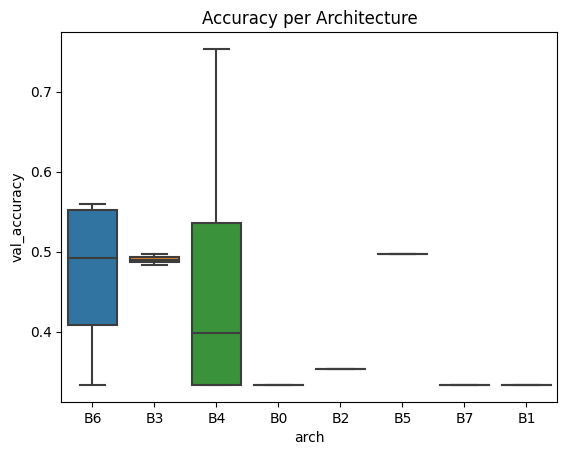

In [21]:
sns.boxplot(x="arch", y="val_accuracy", data=df_results)
plt.title("Accuracy per Architecture")
plt.show()


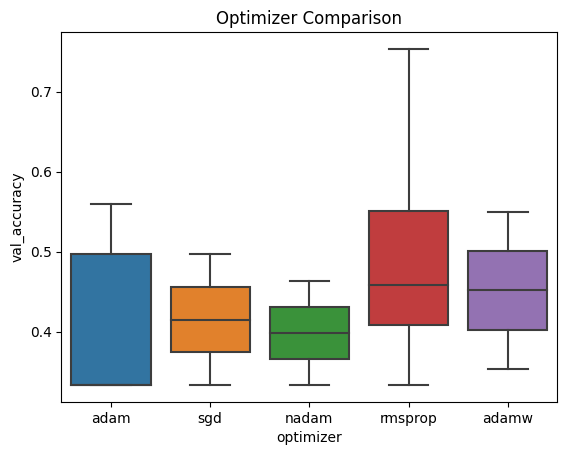

In [22]:
sns.boxplot(x="optimizer", y="val_accuracy", data=df_results)
plt.title("Optimizer Comparison")
plt.show()


In [23]:
best_arch = df_results.loc[df_results["val_accuracy"].idxmax(), "arch"]
best_opt = df_results.loc[df_results["val_accuracy"].idxmax(), "optimizer"]

print("Best Architecture:", best_arch)
print("Best Optimizer:", best_opt)


Best Architecture: B4
Best Optimizer: rmsprop


In [4]:
# Source roots
ds1_root = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256"
ds2_root = "/kaggle/input/potato-leaf-disease-dataset/Potato"

# Target root
merged_root = "/kaggle/working/merged_potato"

splits_map_ds1 = {
    "Training": "train",
    "Validation": "val",
    "Testing": "test",
}

splits_map_ds2 = {
    "Train": "train",
    "Valid": "val",
    "Test": "test",
}

# Class name mapping for ds2 -> common names
class_map_ds2 = {
    "Potato___Early_blight": "Early_Blight",
    "Potato___Late_blight": "Late_Blight",
    "Potato___healthy": "Healthy",
}

common_classes = ["Early_Blight", "Late_Blight", "Healthy"]

# Create target directories
for split in ["train", "val", "test"]:
    for cls in common_classes:
        os.makedirs(os.path.join(merged_root, split, cls), exist_ok=True)

def copy_all(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        return
    for fname in os.listdir(src_dir):
        src_path = os.path.join(src_dir, fname)
        dst_path = os.path.join(dst_dir, fname)
        if os.path.isfile(src_path):
            shutil.copy2(src_path, dst_path)

# 1) Copy from dataset 1 (PLD_3_Classes_256)
for src_split, tgt_split in splits_map_ds1.items():
    for cls in common_classes:
        src_dir = os.path.join(ds1_root, src_split, cls)
        dst_dir = os.path.join(merged_root, tgt_split, cls)
        copy_all(src_dir, dst_dir)

# 2) Copy from dataset 2 (Potato)
for src_split, tgt_split in splits_map_ds2.items():
    src_split_dir = os.path.join(ds2_root, src_split)
    for ds2_cls, common_cls in class_map_ds2.items():
        src_dir = os.path.join(src_split_dir, ds2_cls)
        dst_dir = os.path.join(merged_root, tgt_split, common_cls)
        copy_all(src_dir, dst_dir)

print("Merging done.")


Merging done.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (380, 380)
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.6, 1.4),
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    os.path.join(merged_root, "train"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(merged_root, "val"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    os.path.join(merged_root, "test"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 4151 images belonging to 3 classes.
Found 716 images belonging to 3 classes.
Found 705 images belonging to 3 classes.


In [6]:
base_model = EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(380, 380, 3)
)

fine_tune_at = int(len(base_model.layers) * 0.4612895772522648)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True


I0000 00:00:1765469909.589566      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.22592998884011783)(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)


In [8]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0003052618467119413),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6
)


In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1765469976.176476     171 service.cc:148] XLA service 0x79f28c0035d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765469976.177398     171 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765469981.555827     171 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1765469990.011972     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765469990.197476     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765469990.605522     171 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765469990.8064

  1/519 ━━━━━━━━━━━━━━━━━━━━ 10:05:17 70s/step - accuracy: 0.5000 - loss: 1.0195

I0000 00:00:1765470013.487457     171 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


280/519 ━━━━━━━━━━━━━━━━━━━━ 1:01 258ms/step - accuracy: 0.8924 - loss: 0.2905

E0000 00:00:1765470096.828395     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765470097.013853     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765470097.412162     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765470097.612813     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765470098.177008     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

519/519 ━━━━━━━━━━━━━━━━━━━━ 259s 364ms/step - accuracy: 0.9112 - loss: 0.2478 - val_accuracy: 0.9637 - val_loss: 0.1015 - learning_rate: 3.0526e-04
Epoch 2/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 139s 267ms/step - accuracy: 0.9726 - loss: 0.0886 - val_accuracy: 0.9958 - val_loss: 0.0075 - learning_rate: 3.0526e-04
Epoch 3/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 145s 279ms/step - accuracy: 0.9861 - loss: 0.0511 - val_accuracy: 0.9972 - val_loss: 0.0095 - learning_rate: 3.0526e-04
Epoch 4/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 143s 275ms/step - accuracy: 0.9904 - loss: 0.0402 - val_accuracy: 0.9986 - val_loss: 0.0090 - learning_rate: 3.0526e-04
Epoch 5/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 140s 269ms/step - accuracy: 0.9916 - loss: 0.0261 - val_accuracy: 0.9986 - val_loss: 0.0049 - learning_rate: 9.1579e-05
Epoch 6/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 140s 270ms/step - accuracy: 0.9915 - loss: 0.0327 - val_accuracy: 0.9986 - val_loss: 0.0046 - learning_rate: 9.1579e-05
Epoch 7/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 140s 269ms/

In [11]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9992 - loss: 0.0036
Test Accuracy: 0.9971631169319153
Test Loss: 0.011996163986623287


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step


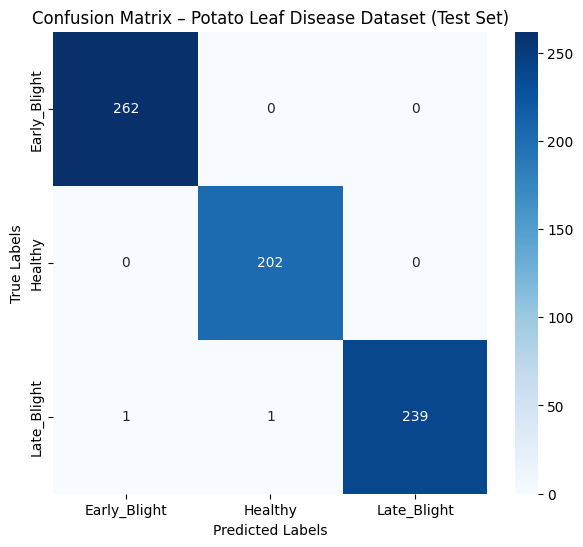

              precision    recall  f1-score   support

Early_Blight       1.00      1.00      1.00       262
     Healthy       1.00      1.00      1.00       202
 Late_Blight       1.00      0.99      1.00       241

    accuracy                           1.00       705
   macro avg       1.00      1.00      1.00       705
weighted avg       1.00      1.00      1.00       705



In [14]:

DATASET_NAME = "Potato Leaf Disease Dataset"

class_labels = list(test_generator.class_indices.keys())

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title(f"Confusion Matrix – {DATASET_NAME} (Test Set)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_labels))


In [15]:
model.save("best_model_potato.h5")
print("Model saved.")


Model saved.


In [16]:
import json
with open("class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)
